# SITC - Proyecto Final: Twitter football analysis

- Crespo Bolaños, Priscila
- Juliana Quiros, Gregorio
- Murillo Ramos, David
- Pascual Landa, Ignacio
- Rodriguez Villalba, Álvaro

## Sentiment classification for Twitter

### Obtención de datos etiquetados

In [1]:
#Leemos el fichero de los datos sin etiquetar
# General import and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# if matplotlib is not set inline, you will not see plots
#alternatives auto gtk gtk2 inline osx qt qt5 wx tk
#%matplotlib auto
#%matplotlib qt
%matplotlib inline
%run plot_learning_curve

tweets = pd.read_csv('football-twitter/train.csv')
tweets.head()

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


,id,text,polarity
0,9f5c7536,Recorriendo el #CampNou🏟 https://t.co/ZKZ1ERaiZS,Neutral
1,8e59cbaa,@FCBarcelona fera desde pequeno😲😲,Neutral
2,a2c38968,@sport Y el barca que haria sin Messi????? Ni ...,Negative
3,51cf6477,Please RT!! #barcelona #fcbarcelona #Barca #fc...,Neutral
4,2a1bb2a5,"@NostradamusFCB Si parce que miedo, sólo el ba...",Neutral


In [2]:
tweets.dtypes

id          object
text        object
polarity    object
dtype: object

In [3]:
tweets.polarity.unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

In [4]:
tweets.groupby('polarity').size()

polarity
Negative    142
Neutral     208
Positive     61
dtype: int64

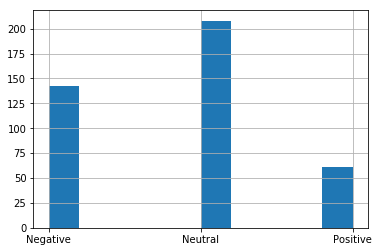

In [5]:
tweets['polarity'].hist()

As we see there are more tweets labeled as Negative than Positive. WE will try to equalize those values.

In [6]:
tweets_negative = tweets[tweets.polarity=='Negative']
tweets_negative.head()
tweets_toDelete = tweets_negative[:-61]
tweets_toDelete.count()

id          81
text        81
polarity    81
dtype: int64

In [7]:
tweets = tweets[~tweets.index.isin(tweets_toDelete.index)]
tweets.head()

,id,text,polarity
0,9f5c7536,Recorriendo el #CampNou🏟 https://t.co/ZKZ1ERaiZS,Neutral
1,8e59cbaa,@FCBarcelona fera desde pequeno😲😲,Neutral
3,51cf6477,Please RT!! #barcelona #fcbarcelona #Barca #fc...,Neutral
4,2a1bb2a5,"@NostradamusFCB Si parce que miedo, sólo el ba...",Neutral
5,7c2deb3b,@Matt_Santangelo Mino= No Barca.,Neutral


In [8]:
tweets.groupby('polarity').size()

polarity
Negative     61
Neutral     208
Positive     61
dtype: int64

In [9]:
tweets_neutral = tweets[tweets.polarity=='Neutral']
tweets_neutral.count()

id          208
text        208
polarity    208
dtype: int64

In [10]:
tweets_neutraltoDelete = tweets_neutral[:-61]
tweets_neutraltoDelete.count()

id          147
text        147
polarity    147
dtype: int64

In [11]:
tweets = tweets[~tweets.index.isin(tweets_neutraltoDelete.index)]
tweets.head()

,id,text,polarity
8,5c5d618c,"Qué maravilla que este chico tocado por Dios, ...",Positive
15,3fc87e2e,¡DE PIE DAMAS Y CABALLEROS! 💃🕴👏\n#HOY se cu...,Positive
19,dfbfbf2f,⚽️🇪🇸| Barça\n\nEl partido de 'Dinho' ese día...,Positive
23,43c66ae0,¡TREMENDO! 🙌 La brutal exhibición de Koke en ...,Positive
24,1f103e4b,Que venga Arthur me tiene más emocionado que c...,Positive


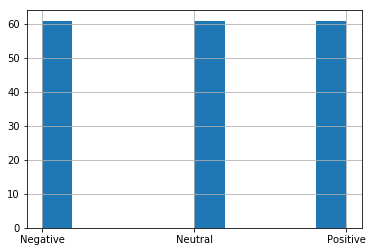

In [12]:
tweets['polarity'].hist()

Now we have a more distributed number of negative, positive and neutral tweets

In [13]:
tweets.shape

(183, 3)

### Tokenizing & Stemming

Once we have our corpus ready, we'll clean the tweets, removing stops words, tokenization, etc

In [14]:
#Palabras parada
import nltk
nltk.download("stopwords")
nltk.download('punkt')

from nltk.corpus import stopwords
spanish_stopwords = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/assistant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/assistant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
print(spanish_stopwords)

[u'de', u'la', u'que', u'el', u'en', u'y', u'a', u'los', u'del', u'se', u'las', u'por', u'un', u'para', u'con', u'no', u'una', u'su', u'al', u'lo', u'como', u'm\xe1s', u'pero', u'sus', u'le', u'ya', u'o', u'este', u's\xed', u'porque', u'esta', u'entre', u'cuando', u'muy', u'sin', u'sobre', u'tambi\xe9n', u'me', u'hasta', u'hay', u'donde', u'quien', u'desde', u'todo', u'nos', u'durante', u'todos', u'uno', u'les', u'ni', u'contra', u'otros', u'ese', u'eso', u'ante', u'ellos', u'e', u'esto', u'm\xed', u'antes', u'algunos', u'qu\xe9', u'unos', u'yo', u'otro', u'otras', u'otra', u'\xe9l', u'tanto', u'esa', u'estos', u'mucho', u'quienes', u'nada', u'muchos', u'cual', u'poco', u'ella', u'estar', u'estas', u'algunas', u'algo', u'nosotros', u'mi', u'mis', u't\xfa', u'te', u'ti', u'tu', u'tus', u'ellas', u'nosotras', u'vosostros', u'vosostras', u'os', u'm\xedo', u'm\xeda', u'm\xedos', u'm\xedas', u'tuyo', u'tuya', u'tuyos', u'tuyas', u'suyo', u'suya', u'suyos', u'suyas', u'nuestro', u'nuestra', 

In [16]:
#Signos de puntuación
from string import punctuation
non_words = list(punctuation)

#we add spanish punctuation
non_words.extend(['¿', '¡', '\u200d', '—', '“', '”', '…', '\U0001f929', '‘', '’'])
non_words.extend(map(str,range(10)))

In [17]:
non_words

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 '\xc2\xbf',
 '\xc2\xa1',
 '\\u200d',
 '\xe2\x80\x94',
 '\xe2\x80\x9c',
 '\xe2\x80\x9d',
 '\xe2\x80\xa6',
 '\\U0001f929',
 '\xe2\x80\x98',
 '\xe2\x80\x99',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [18]:
from sklearn.feature_extraction.text import CountVectorizer       
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)

# based on http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html
stemmer = LancasterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    # remove non letters
    text = ''.join([c for c in text if c not in non_words])
    # tokenize
    tokens =  tweet_tokenizer.tokenize(text)

    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

## Evaluación del modelo

In [19]:
from sklearn.cross_validation import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

First, we will categorize the sentiment.
- Negative sentiments:0
- Positive sentiments:1
- Neutral sentiments:2

In [20]:
tweets['polarity_bin'] = 0
tweets.polarity_bin[tweets.polarity=='Positive'] = 1
tweets.polarity_bin[tweets.polarity=='Negative'] = 0
tweets.polarity_bin[tweets.polarity=='Neutral'] = 2

tweets.polarity_bin.value_counts(normalize=True)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


2    0.333333
1    0.333333
0    0.333333
Name: polarity_bin, dtype: float64

Once we have a binary classification problem, the score will be the Area Under Curve (roc_auc). We will use in this case the Linear Support Vector Classifier, and use the Gird Search to optimize the parameters to use.

Now we create the model with the optimized parameters

In [21]:
from sklearn.cross_validation import cross_val_score, KFold

vectorizer = CountVectorizer(
            analyzer = 'word',
            tokenizer = tokenize,
            lowercase = True,
            stop_words = spanish_stopwords,
            max_features=5000
            )

pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', LinearSVC()),
])
#Aprender el vocabulario
tweets_features = vectorizer.fit_transform(tweets.text)
tweets_features_nd = tweets_features.toarray()
#Evaluacion del modelo
scores = cross_val_score(pipeline, tweets.text, tweets.polarity_bin, cv=5)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


('Scores in every iteration', array([0.53846154, 0.44444444, 0.30555556, 0.44444444, 0.41666667]))
Accuracy: 0.43 (+/- 0.15)


In [22]:
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.naive_bayes import MultinomialNB


pipeline_NB = Pipeline([
    ('vect', vectorizer),
    ('cls', MultinomialNB()),
])
#Aprender el vocabulario
tweets_features = vectorizer.fit_transform(tweets.text)
tweets_features_nd = tweets_features.toarray()

param_grid = {    
    'vect__max_features': [1000, 2500, 5000],
    'vect__ngram_range': [[1, 1], [2, 2]],  # unigrams or bigrams
    'cls__alpha': [0.1,0.5,1.0],
} 

gs = GridSearchCV(pipeline_NB, param_grid)

gs.fit(tweets.text, tweets.polarity_bin)

# summarize the results of the grid search
print("Best score: ", gs.best_score_)
print("Best params: ", gs.best_params_)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


('Best score: ', 0.5136612021857924)
('Best params: ', {'vect__ngram_range': [1, 1], 'cls__alpha': 1.0, 'vect__max_features': 2500})


In [23]:
#Regresion lineal
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression


pipeline_LogR = Pipeline([
    ('vect', vectorizer),
    ('lr', LogisticRegression(n_jobs=-1)),
])
#Aprender el vocabulario
tweets_features = vectorizer.fit_transform(tweets.text)
tweets_features_nd = tweets_features.toarray()

scores = cross_val_score(pipeline_LogR, tweets.text, tweets.polarity_bin, cv=5)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()
/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


('Scores in every iteration', array([0.61538462, 0.44444444, 0.30555556, 0.5       , 0.44444444]))
Accuracy: 0.46 (+/- 0.20)


In [24]:
#Knn
from sklearn.neighbors import KNeighborsClassifier
pipeline_knn = Pipeline([
    ('vect', vectorizer),
    ('knn', KNeighborsClassifier()),
])
#Aprender el vocabulario
tweets_features = vectorizer.fit_transform(tweets.text)
tweets_features_nd = tweets_features.toarray()

scores = cross_val_score(pipeline_knn, tweets.text, tweets.polarity_bin, cv=5)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


('Scores in every iteration', array([0.38461538, 0.33333333, 0.30555556, 0.38888889, 0.38888889]))
Accuracy: 0.36 (+/- 0.07)


In [25]:
#MPL
from sklearn.neural_network import MLPClassifier

pipeline_mpl = Pipeline([
    ('vect', CountVectorizer(
            analyzer = 'word',
            tokenizer = tokenize,
            lowercase = True,
            stop_words = spanish_stopwords,
            )),
    ('mpl', MLPClassifier(max_iter=500)),
])
#Aprender el vocabulario
tweets_features = vectorizer.fit_transform(tweets.text)
tweets_features_nd = tweets_features.toarray()

param_grid = {    
    'vect__max_features': [1000, 3000, 4000],
    'vect__ngram_range': [[1, 1], [2, 2]],  # unigrams or bigrams
    'mpl__hidden_layer_sizes': [(100,), (200,)]
} 

gs = GridSearchCV(pipeline_mpl, param_grid)

gs.fit(tweets.text, tweets.polarity_bin)

# summarize the results of the grid search
print("Best score: ", gs.best_score_)
print("Best params: ", gs.best_params_)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


('Best score: ', 0.47540983606557374)
('Best params: ', {'vect__ngram_range': [1, 1], 'mpl__hidden_layer_sizes': (100,), 'vect__max_features': 1000})


In [26]:
from sklearn import tree

#Decision Tree
pipeline_dt = Pipeline([
    ('vect', vectorizer),
    ('dt', tree.DecisionTreeClassifier()),
])
#Aprender el vocabulario
tweets_features = vectorizer.fit_transform(tweets.text)
tweets_features_nd = tweets_features.toarray()

scores = cross_val_score(pipeline_dt, tweets.text, tweets.polarity_bin, cv=5)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


('Scores in every iteration', array([0.41025641, 0.38888889, 0.47222222, 0.33333333, 0.33333333]))
Accuracy: 0.39 (+/- 0.10)


In [27]:
#Cargamos el fichero de tweets sin etiquetar
tweets_nolabel = pd.read_csv('football-twitter/test_nolabel.csv')
tweets_nolabel.head()

,id,text
0,aa24173d,Han robado por el método del alunizaje en la t...
1,79cdded5,@BenditalocuraAt @Atleti @fhervas13 FELICIDADE...
2,26fe7471,Dedicado para:\n@Trigueros17 \n@FCBarcelona ht...
3,d7d87d07,@Eribert42354852 El Barca aparte de ganar eso ...
4,c4852036,Vengo 2/2 con los clasificados a Cuartos de Ch...


In [28]:
tweets_nolabel.shape

(177, 2)

In [29]:
tweets_nolabel.dtypes

id      object
text    object
dtype: object

In [30]:
#Entrenamos el modelo con los datos del corpus
pipeline.fit(tweets.text, tweets.polarity_bin)
#Realizamos las predicciones con los datos descargados directamente de Twitter
#tweets['polarity'] = pipeline.predict(tweets_nolabel.text)
#tweets[['tweet', 'polarity']].sample(20)

polarity=pipeline.predict(tweets_nolabel.text)
dataframeResult = pd.read_csv('football-twitter/test_nolabel.csv').filter(['id'], axis=1)
dataframeResult['Polarity'] = polarity
dataframeResult[:]
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([0], 'Negative')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([1], 'Positive')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([2], 'Neutral')

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


In [31]:
dataframeResult.to_csv('out_svc.csv', sep=',',index=False)

In [32]:
#Entrenamos el modelo con los datos del corpus
pipeline_NB.fit(tweets.text, tweets.polarity_bin)
#Realizamos las predicciones con los datos descargados directamente de Twitter
#tweets['polarity'] = pipeline.predict(tweets_nolabel.text)
#tweets[['tweet', 'polarity']].sample(20)

polarity=pipeline_NB.predict(tweets_nolabel.text)
dataframeResult = pd.read_csv('football-twitter/test_nolabel.csv').filter(['id'], axis=1)
dataframeResult['Polarity'] = polarity
dataframeResult[:]
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([0], 'Negative')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([1], 'Positive')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([2], 'Neutral')
dataframeResult.to_csv('out_nb.csv', sep=',',index=False)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


In [33]:
#Entrenamos el modelo con los datos del corpus
pipeline_LogR.fit(tweets.text, tweets.polarity_bin)
#Realizamos las predicciones con los datos descargados directamente de Twitter
#tweets['polarity'] = pipeline.predict(tweets_nolabel.text)
#tweets[['tweet', 'polarity']].sample(20)

polarity=pipeline_LogR.predict(tweets_nolabel.text)
dataframeResult = pd.read_csv('football-twitter/test_nolabel.csv').filter(['id'], axis=1)
dataframeResult['Polarity'] = polarity
dataframeResult[:]
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([0], 'Negative')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([1], 'Positive')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([2], 'Neutral')
dataframeResult.to_csv('out_LogR.csv', sep=',',index=False)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


In [34]:
#Entrenamos el modelo con los datos del corpus
pipeline_knn.fit(tweets.text, tweets.polarity_bin)
#Realizamos las predicciones con los datos descargados directamente de Twitter
#tweets['polarity'] = pipeline.predict(tweets_nolabel.text)
#tweets[['tweet', 'polarity']].sample(20)

polarity=pipeline_knn.predict(tweets_nolabel.text)
dataframeResult = pd.read_csv('football-twitter/test_nolabel.csv').filter(['id'], axis=1)
dataframeResult['Polarity'] = polarity
dataframeResult[:]
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([0], 'Negative')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([1], 'Positive')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([2], 'Neutral')
dataframeResult.to_csv('out_knn.csv', sep=',',index=False)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


In [35]:
#Entrenamos el modelo con los datos del corpus
pipeline_mpl.fit(tweets.text, tweets.polarity_bin)
#Realizamos las predicciones con los datos descargados directamente de Twitter
#tweets['polarity'] = pipeline.predict(tweets_nolabel.text)
#tweets[['tweet', 'polarity']].sample(20)

polarity=pipeline_mpl.predict(tweets_nolabel.text)
dataframeResult = pd.read_csv('football-twitter/test_nolabel.csv').filter(['id'], axis=1)
dataframeResult['Polarity'] = polarity
dataframeResult[:]
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([0], 'Negative')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([1], 'Positive')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([2], 'Neutral')
dataframeResult.to_csv('out_mpl.csv', sep=',',index=False)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


In [36]:
#Entrenamos el modelo con los datos del corpus
pipeline_dt.fit(tweets.text, tweets.polarity_bin)
#Realizamos las predicciones con los datos descargados directamente de Twitter
#tweets['polarity'] = pipeline.predict(tweets_nolabel.text)
#tweets[['tweet', 'polarity']].sample(20)

polarity=pipeline_dt.predict(tweets_nolabel.text)
dataframeResult = pd.read_csv('football-twitter/test_nolabel.csv').filter(['id'], axis=1)
dataframeResult['Polarity'] = polarity
dataframeResult[:]
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([0], 'Negative')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([1], 'Positive')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([2], 'Neutral')
dataframeResult.to_csv('out_dt.csv', sep=',',index=False)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()
